In [1]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve,auc
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MinMaxScaler
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

2023-12-18 01:47:38.041969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 01:47:38.042172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 01:47:38.058866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 01:47:38.119336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 01:47:39.920768: W tensorflow/compiler/tf2

In [2]:

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, inputs_f, targets in test_loader:
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            outputs = model(inputs, inputs_f)
            outputs = torch.squeeze(outputs)  

            # Convert outputs to predicted labels
            predicted_labels = (outputs > 0.5).float()  # Using 0.5 as threshold for binary classification

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    output = np.array(output)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr_roc, tpr_roc, _ = metrics.roc_curve(y_true, output)
    roc = metrics.auc(fpr_roc, tpr_roc)

    return accuracy, precision, recall, f1, roc



def prc(model,test_loader,device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    output = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, inputs_f, targets in test_loader:
            inputs, inputs_f, targets = inputs.to(device), inputs_f.to(device), targets.to(device)
            outputs = model(inputs, inputs_f)
            outputs = torch.squeeze(outputs)  

            # Convert outputs to predicted labels
            # predicted_labels = (outputs > 0.5).float()  # Using 0.5 as threshold for binary classification
            predicted_labels = outputs

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())
            output.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    output = np.array(y_pred)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, output)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(12, 5))

    # Plotting Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.text(0.5, 0.4, f'AUC = {pr_auc:.2f}', fontsize=12)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, output)
    roc_auc = auc(fpr, tpr)

    # Plotting ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12)

    plt.tight_layout()
    plt.show()



def encode_smiles_batch(smiles_list, tokenizer, model, batch_size=32):
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            output = model(**inputs)
        batch_embeddings = output.last_hidden_state.mean(dim=1)  # Mean pooling
        embeddings.append(batch_embeddings)

    return torch.cat(embeddings, dim=0)



class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        # Convert the inputs to a format suitable for your model
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label).float()



# 2. Create a custom model class
class Bertish(nn.Module):
    def __init__(self, pre_trained_model):
        super(Bertish, self).__init__()
        self.pre_trained_model = pre_trained_model
        self.linear = nn.Linear(768, 1)
        self.sig= nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.pre_trained_model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        # Apply the linear layer to the last hidden state
        return self.sig(self.linear(last_hidden_state[:, 0, :]))



In [3]:
pretrain_choice= 2    # 1,2,3

# Initialize tokenizer and model
if pretrain_choice==1:
    tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
    model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

elif pretrain_choice==2:
    tokenizer=AutoTokenizer.from_pretrained("pchanda/pretrained-smiles-pubchem10m")
    model=AutoModel.from_pretrained("pchanda/pretrained-smiles-pubchem10m")

elif pretrain_choice==3:
    tokenizer=AutoTokenizer.from_pretrained("HUBioDataLab/SELFormer")
    model=AutoModel.from_pretrained("HUBioDataLab/SELFormer")

else:
    print('Please choose between 1, 2 or 3 for pretrain_choice')




def custom_collate_fn(batch):
    input_ids, attention_mask, labels = zip(*batch)

    # Pad sequences so they are all the same length within a batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    labels = torch.stack(labels)

    return input_ids_padded, attention_mask_padded, labels

cmpd_df = pd.read_csv('cmpd.csv')

# Example list of SMILES
smiles_list = np.array(cmpd_df.smiles.tolist())
y = cmpd_df.activity.eq('active').astype(float).to_numpy()


train_test=cmpd_df.group.tolist()

train_indices = np.array(train_test) == 'train'
test_indices = np.array(train_test) == 'test'


train_smiles=smiles_list[train_indices]
train_y=y[train_indices]
test_smiles=smiles_list[test_indices]
test_y=y[test_indices]

# Create an instance of your custom dataset
train_dataset = TextDataset(train_smiles, train_y, tokenizer)
test_dataset = TextDataset(test_smiles, test_y, tokenizer)

# Create DataLoader
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=custom_collate_fn)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=custom_collate_fn)


Some weights of RobertaModel were not initialized from the model checkpoint at pchanda/pretrained-smiles-pubchem10m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




Training on cuda
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2070 Super', major=7, minor=5, total_memory=8191MB, multi_processor_count=40)

Trainable Parameters: 769/83451649

********************
Experiment 1/1
********************

Fast learning of Augemnted Layer...

Epoch: 1/70, Loss: 0.5989
Train Accuracy: 0.6945, Precision: 0.8441, Recall: 0.5322, F1 Score: 0.6528, AUC-ROC: 0.7762
Test Accuracy: 0.7096, Precision: 0.6588, Recall: 0.3978, F1 Score: 0.4961, AUC-ROC: 0.7447
---------------------------------------------------------------------------------------------------------
Epoch: 10/70, Loss: 0.5301
Train Accuracy: 0.7470, Precision: 0.7830, Recall: 0.7349, F1 Score: 0.7582, AUC-ROC: 0.8290
Test Accuracy: 0.7173, Precision: 0.6035, Recall: 0.6219, F1 Score: 0.6125, AUC-ROC: 0.7741
---------------------------------------------------------------------------------------------------------
Epoch: 20/70, Loss: 0.5221
Train Accuracy: 0.7596, Precision: 0.8512, Recall: 0.6719, F1 

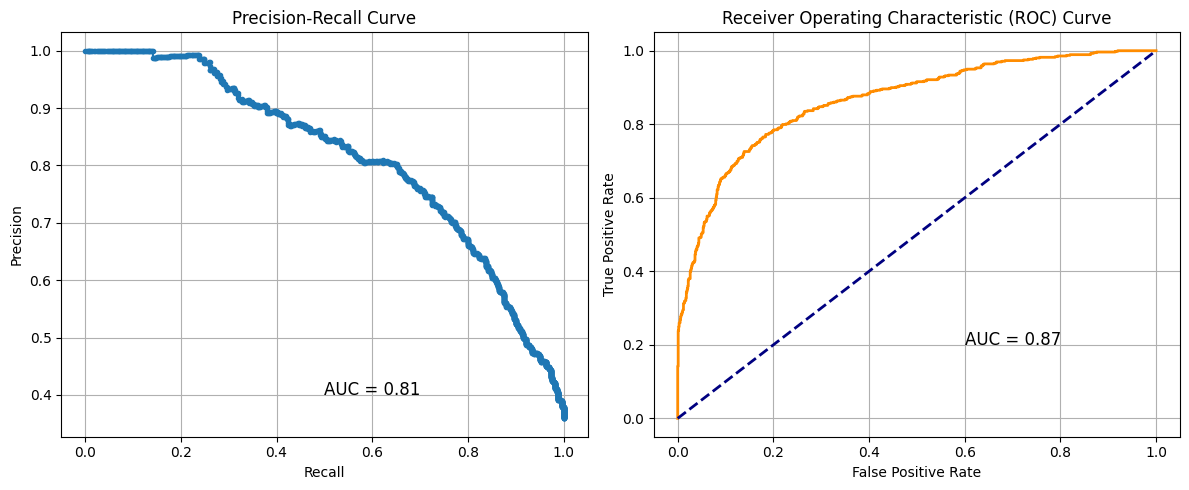

In [4]:
total_epochs = 70
lr = 1e-3
T_max =  91
eta_min = 6.545953120158012e-05
num_experiments = 1
mntum = 0.8632101088311456
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = torch.nn.BCELoss()
test_acc=[]


print('\n\nTraining on {}'.format(device))
print(torch.cuda.get_device_properties(device))
print('========================================================\n')


for exp in range(num_experiments):
    # Initialize the model
    model=Bertish(model)
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8629161261798225)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)


    # make all layers of model untrainable except last Linear layer
    for param in model.parameters():
        param.requires_grad = False

    for param in model.linear.parameters():
        param.requires_grad = True

    # count number of trainable parameters to total_params
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable Parameters: {}/{}'.format(total_params, sum(p.numel() for p in model.parameters())))


    # train model
    print('\n********************')
    print('Experiment {}/{}'.format(exp+1, num_experiments))
    print('********************\n')

    print("Fast learning of Augemnted Layer...\n")
    for epoch in range(total_epochs):
        run_loss = 0.0
        for i, (input_ids, attention_mask, targets) in enumerate(train_loader):
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            # outputs = torch.squeeze(outputs)
            targets = torch.unsqueeze(targets, 1)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
        
        run_loss /= len(train_loader)


        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
            train_accuracy, train_precision, train_recall, train_f1,  train_roc = evaluate_model(model, train_loader, device)
            test_accuracy, test_precision, test_recall, test_f1, test_roc = evaluate_model(model, test_loader, device)

            print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
            print('Train Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(train_accuracy, train_precision, train_recall, train_f1, train_roc))
            print('Test Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(test_accuracy, test_precision, test_recall, test_f1, test_roc))

            model.train()
            print("---------------------------------------------------------------------------------------------------------")

        scheduler.step()

    #--------------------------------------------------------------------------
    print("\n\nSlow learning of whole model...\n")
    total_epochs= 100

    for param in model.parameters():
        param.requires_grad = True

    lr=1e-4
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8629161261798225)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
    
    for epoch in range(total_epochs):
        run_loss = 0.0
        for i, (input_ids, attention_mask, targets) in enumerate(train_loader):
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            # outputs = torch.squeeze(outputs)
            targets = torch.unsqueeze(targets, 1)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
        
        run_loss /= len(train_loader)


        if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
            train_accuracy, train_precision, train_recall, train_f1,  train_roc = evaluate_model(model, train_loader, device)
            test_accuracy, test_precision, test_recall, test_f1, test_roc = evaluate_model(model, test_loader, device)

            print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
            print('Train Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(train_accuracy, train_precision, train_recall, train_f1, train_roc))
            print('Test Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(test_accuracy, test_precision, test_recall, test_f1, test_roc))

            model.train()
            print("---------------------------------------------------------------------------------------------------------")

        scheduler.step()


    prc(model,test_loader,device) 
    torch.save(model.state_dict(), 'model_exp'+str(exp)+'_'+str(test_accuracy)+'acc.pt')
    test_acc.append(test_accuracy) 

    print('\n')   




Epoch: 1/70, Loss: 0.2311
Train Accuracy: 0.9180, Precision: 0.9624, Recall: 0.8826, F1 Score: 0.9208, AUC-ROC: 0.9800
Test Accuracy: 0.8133, Precision: 0.7597, Recall: 0.7025, F1 Score: 0.7300, AUC-ROC: 0.8661
---------------------------------------------------------------------------------------------------------


Epoch: 10/70, Loss: 0.1753
Train Accuracy: 0.9671, Precision: 0.9791, Recall: 0.9595, F1 Score: 0.9692, AUC-ROC: 0.9958
Test Accuracy: 0.8120, Precision: 0.7293, Recall: 0.7581, F1 Score: 0.7434, AUC-ROC: 0.8715
---------------------------------------------------------------------------------------------------------
Epoch: 20/70, Loss: 0.1120
Train Accuracy: 0.9867, Precision: 0.9892, Recall: 0.9860, F1 Score: 0.9876, AUC-ROC: 0.9995
Test Accuracy: 0.8113, Precision: 0.7288, Recall: 0.7563, F1 Score: 0.7423, AUC-ROC: 0.8735
---------------------------------------------------------------------------------------------------------
Epoch: 30/70, Loss: 0.0706
Train Accuracy: 0.9922, Precision: 0.9930, Recall: 0.9925, F1 Score: 0.9928, AUC-ROC: 0.9997
Test Accuracy: 0.8036, Precision: 0.7112, Recall: 0.7634, F1 Score: 0.7364, AUC-ROC: 0.8683
---------------------------------------------------------------------------------------------------------
Epoch: 40/70, Loss: 0.0508
Train Accuracy: 0.9

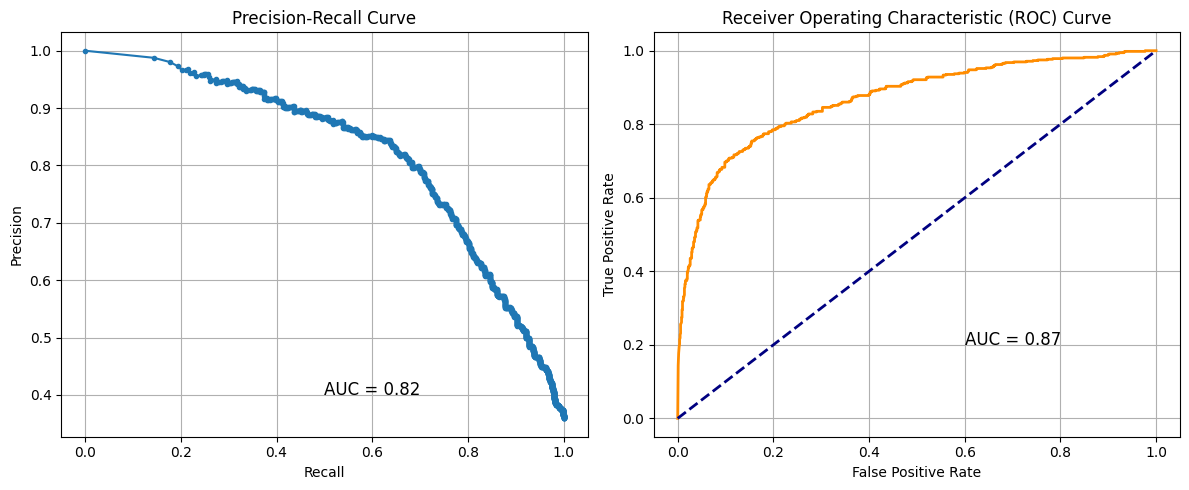

In [5]:
total_epochs= 70

for param in model.parameters():
    param.requires_grad = True

lr=1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8629161261798225)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

for epoch in range(total_epochs):
    run_loss = 0.0
    for i, (input_ids, attention_mask, targets) in enumerate(train_loader):
        input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        # outputs = torch.squeeze(outputs)
        targets = torch.unsqueeze(targets, 1)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        run_loss += loss.item()
    
    run_loss /= len(train_loader)


    if (epoch+1) % 10 == 0 or epoch == 0 or epoch == total_epochs-1:
        train_accuracy, train_precision, train_recall, train_f1,  train_roc = evaluate_model(model, train_loader, device)
        test_accuracy, test_precision, test_recall, test_f1, test_roc = evaluate_model(model, test_loader, device)

        print('Epoch: {}/{}, Loss: {:.4f}'.format(epoch+1, total_epochs, run_loss))
        print('Train Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(train_accuracy, train_precision, train_recall, train_f1, train_roc))
        print('Test Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}, AUC-ROC: {:.4f}'.format(test_accuracy, test_precision, test_recall, test_f1, test_roc))

        model.train()
        print("---------------------------------------------------------------------------------------------------------")

    scheduler.step()


prc(model,test_loader,device) 
torch.save(model.state_dict(), 'model_exp'+str(exp)+'_'+str(test_accuracy)+'acc.pt')
test_acc.append(test_accuracy) 

print('\n')   
